In [1]:
from pyspark.sql import SparkSession
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
print(os.getenv("JAVA_HOME"))
# Create SparkSession
spark = SparkSession.builder\
    .config("spark.driver.memory", "16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:4.0.0,org.neo4j:neo4j-connector-apache-spark_2.12:4.1.2_for_spark_3")\
    .getOrCreate()

/usr/lib/jvm/java-11-openjdk-amd64


22/06/21 08:15:25 WARN Utils: Your hostname, pop-os resolves to a loopback address: 127.0.1.1; using 192.168.0.178 instead (on interface enp4s0)
22/06/21 08:15:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/vergenter/Venvs/sparkNLPVenv/lib/python3.10/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/vergenter/.ivy2/cache
The jars for the packages stored in: /home/vergenter/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.neo4j#neo4j-connector-apache-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d9b1b7a1-5b29-48a0-aff8-bacefd767f20;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.0.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	fo

In [2]:
degrees = spark.read.format("org.neo4j.spark.DataSource")\
  .option("url", "bolt://192.168.0.178:7687")\
  .option("authentication.basic.username", os.environ["NEO4J_LOGIN"])\
  .option("authentication.basic.password", os.environ["NEO4J_PASSWORD"])\
  .option("query", "MATCH (n:Article) WITH n RETURN n.inDegree as degree,count(n.inDegree) as count ORDER BY degree")\
  .option("partitions", "4")\
  .load()

<AxesSubplot:xlabel='degree'>

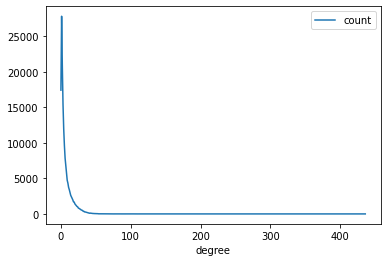

In [8]:
df_degree = degrees.toPandas()
df_degree.plot(x="degree",y="count")

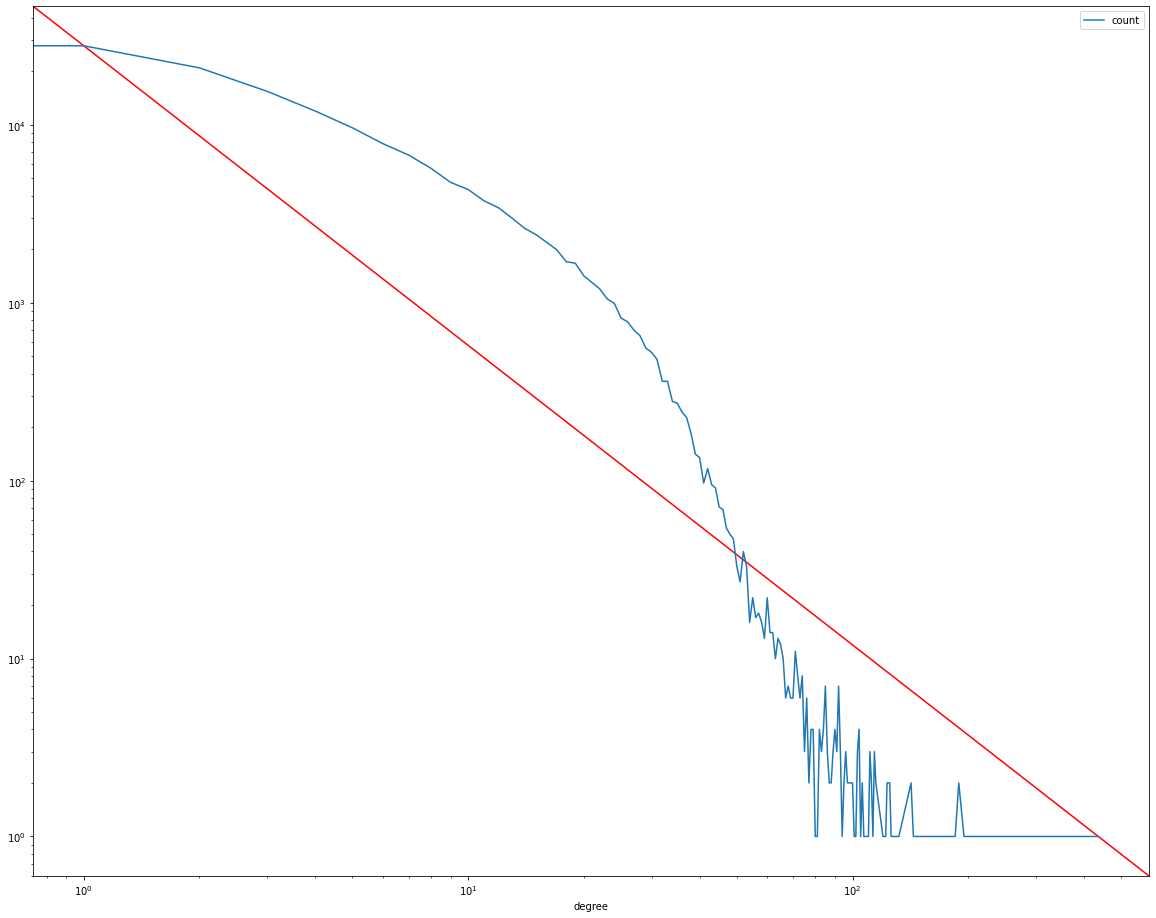

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize = (20,16))
axs.plot([1,0],[0,1], transform=axs.transAxes,color="red")
df_degree.plot(x="degree",y="count",ax=axs)
plt.xscale("log")
plt.yscale("log")

In [10]:
import numpy as np
import powerlaw
data = df_degree.iloc[:,1:].values.flatten() # data can be list or numpy array
data2 = df_degree.iloc[1:,1:].values.flatten()
results = powerlaw.Fit(data,discrete=True)
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'lognormal')
print(R,p)

Calculating best minimal value for power law fit
1.2743559480159965
1.0
-2.3477666730940228 0.002117887995201499


<AxesSubplot:>

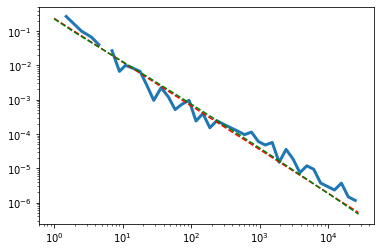

In [11]:
fig4 = results.plot_pdf(linewidth=3)
results.power_law.plot_pdf(ax=fig4, color='r', linestyle='--')
results.lognormal.plot_pdf(ax=fig4, color='g', linestyle='--')

In [12]:
print("mean",np.mean(df_degree.iloc[:,1:].values.flatten()))
print("median",np.median(df_degree.iloc[:,1:].values.flatten()))

mean 1136.5369127516778
median 6.0
